In [1]:
# Parameters
# Refer to injected parameters for any run.ipynb (similar cell below)
fname = 'BY4741_FKS1-HS2_single_ortho_anidulafungin_variant_data_merge.tsv'

min_input_readcount_high = 10
min_input_readcount_mid = 3

In [2]:
# Parameters
fname = "BY4741_FKS2-HS1_single_ortho_none_variant_data_merge.tsv"
min_input_readcount_high = 10
min_input_readcount_mid = 3


# Master notebook to analyze DMS data

## Import libraries

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
from upsetplot import from_indicators
from upsetplot import UpSet

## Functions

## Specify paths

In [4]:
metadata_path = 'data/'
variantdata_path = 'dimsum_output/variant_data/'
dimsumfitness_path = 'dimsum_output/fitness_data/'
expdesign_path = 'dimsum_expdesign/'
codon_table_path = 'data/general_use/ScerevisiaeTAXID559292_Cocoputs_codon_table.csv'

processed_data_outpath = 'processed_data/'
graph_outpath = 'graphs/'

## Analysis

In [5]:
f = variantdata_path+fname
pos_offset = {'FKS1-HS1': 639,
              'FKS1-HS2': 1353,
              'FKS2-HS1': 659,
              'FKS2-HS2': 1372
             }

### Get conditions from filename

In [6]:
cset = f.split('/')[-1].split('_')[:-3] # Extract conditions from name of file
cset_name = '_'.join(cset) # Basename based on conditions
strain, locus, pool_type, compound = [cset[i] for i in (0,1,2,-1)]
print(f'Strain: {strain}')
print(f'Locus: {locus}')
print(f'Pool type: {pool_type}')
print(f'Compound: {compound}')

Strain: BY4741
Locus: FKS2-HS1
Pool type: single
Compound: none


In [7]:
if pool_type == 'single':
    nhamaa = 1
elif pool_type == 'double':
    nhamaa = 2
else:
    print('Could not determine pool type')

### Create output folders if they don't already exist

In [8]:
if not os.path.exists(processed_data_outpath+cset_name):
    os.makedirs(processed_data_outpath+cset_name)
if not os.path.exists(graph_outpath+cset_name):
    os.makedirs(graph_outpath+cset_name)

### Read dataframe

In [9]:
df = pd.read_csv(f, sep='\t', header=0, dtype={'WT': 'boolean'}) # Boolean type supports missing data, helps pandas interpret column content
df

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,output1none1_e1_s1_b1_count,output1none2_e1_s1_b2_count,...,output3none3_e3_s1_b3_count,input1_e1_s0_bNA_count,input2_e2_s0_bNA_count,input3_e3_s0_bNA_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aaaatactgtcactaagagatcca,KILSLRDP,<NA>,False,False,2.0,1.0,1.0,1,0,...,0,0,0,0,True,False,True,True,False,False
1,aaaattagaccattgattgctcca,KIRPLIAP,<NA>,False,False,12.0,5.0,7.0,0,0,...,0,0,1,0,True,False,True,True,False,False
2,aaagatactgtcactaagagatcca,KDTVTKRS,<NA>,False,False,NaN,NaN,NaN,0,0,...,0,0,0,1,True,True,True,NaN,NaN,NaN
3,aaagctgtcactaagaccgcca,KAVTKTA,<NA>,False,False,NaN,NaN,NaN,0,0,...,0,0,1,0,True,True,True,NaN,NaN,NaN
4,aaagctgtcactaagagatcca,KAVTKRS,<NA>,False,False,NaN,NaN,NaN,6,5,...,5,6,2,5,True,True,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6426,ttttttatactgtcactaagagataca,FFILSLRDT,<NA>,False,False,NaN,NaN,NaN,1,0,...,0,0,0,0,True,True,True,NaN,NaN,NaN
6427,ttttttatactgtcactaagagatcca,FFILSLRDP,<NA>,False,False,NaN,NaN,NaN,1,3,...,1,2,2,2,True,True,True,NaN,NaN,NaN
6428,ttttttctttgtcttttagagatcca,FFLCLLEI,<NA>,False,False,NaN,NaN,NaN,2,0,...,0,1,1,0,True,True,True,NaN,NaN,NaN
6429,ttttttgtctttgtctttgagagatcca,FFVFVFERS,<NA>,False,False,NaN,NaN,NaN,0,0,...,0,1,0,0,True,True,True,NaN,NaN,NaN


In [10]:
# Extract sample names, based on naming pattern in experimental design file (input/output)
input_conditions = [x for x in df.columns if 'input' in x]
output_conditions = [x for x in df.columns if ('output' in x) & ('_e1_' in x)]
duplicated_output = [x for x in df.columns if ('output' in x) & ('_e1_' not in x)]
input_samples = [x.split('_')[0] for x in input_conditions]
output_samples = [x.split('_')[-2] for x in output_conditions]
conditions = input_samples+output_samples
print(conditions)

['input1', 'input2', 'input3', 'b1', 'b2', 'b3']


#### ⚠️ **Filtering step** ⚠️ - Formatting

In [11]:
# Drop redundant columns due to duplicates in experimental design file
df.drop(columns=duplicated_output, inplace=True)
df.rename(columns=lambda x: x.split('_')[0] if 'input' in x else x, inplace=True)
df.rename(columns=lambda x: x.split('_')[-2] if 'output' in x else x, inplace=True)

In [12]:
# Extract WT sequences (nucleotide and protein)
wtseq = df.loc[df.WT==True, 'nt_seq'].values[0]
wtaa = df.loc[df.WT==True, 'aa_seq'].values[0]
print(f'WT (nt): {wtseq} | (aa): {wtaa}')

WT (nt): ctaatactgtcactaagagatcca | (aa): LILSLRDP


### Mean readcount per variant (raw data)

This matrix shows the average readcount per unique nucleotide sequence per number of mutated codons across samples.

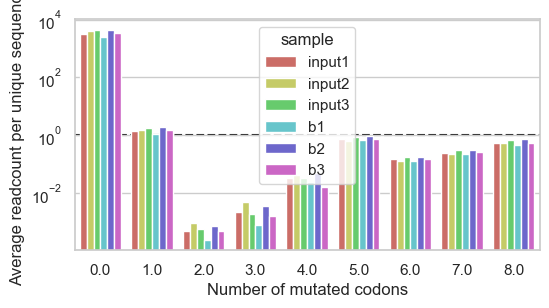

In [13]:
# Purge graph space
sns.set(rc = {'figure.figsize':(6,3)})
sns.set_theme(style='whitegrid')
f, ax = plt.subplots()

count_per_mut_codon = df.groupby('Nmut_codons')[conditions].count()
mean_rc_per_variant = df.groupby('Nmut_codons')[conditions].mean() / count_per_mut_codon
mean_rc_per_variant.reset_index(inplace=True)
mean_rc_long = mean_rc_per_variant.melt(id_vars=['Nmut_codons'], value_vars=conditions, var_name='sample')
sns.barplot(mean_rc_long, x='Nmut_codons',y='value',hue='sample',palette='hls')
plt.yscale('log')
plt.ylabel('Average readcount per unique sequence')
plt.xlabel('Number of mutated codons')
plt.axhline(y=1, linestyle='--', c='k', zorder=-10)

### Overrepresented variants (raw data)

The table below shows the 5 most represented sequences (mean readcount across samples) in % read depth per sample.

#### Overrepresented variants in input samples

In [14]:
overrep_index = df[input_samples].mean(axis=1).sort_values(ascending=False).index[:5]
overrep = 100*round(df.iloc[overrep_index][conditions] / df[conditions].sum(axis=0), 4)
pd.concat([overrep, df.iloc[overrep_index][['nt_seq', 'aa_seq', 'Nmut_codons']]], axis=1)

,input1,input2,input3,b1,b2,b3,nt_seq,aa_seq,Nmut_codons
2684,1.66,1.85,1.81,1.66,1.73,1.70,ctaatactgtcactaagagatcca,LILSLRDP,0.0
3463,0.97,0.96,0.99,1.02,0.95,1.00,ctaatactgttgctaagagatcca,LILLLRDP,1.0
849,0.86,0.89,0.90,0.84,0.90,0.84,atgatactgtcactaagagatcca,MILSLRDP,1.0
2615,0.83,0.91,0.85,0.85,0.85,0.79,ctaatactgtcactaagacatcca,LILSLRHP,1.0
3655,0.89,0.72,0.84,0.88,0.93,0.89,ctaatagtttcactaagagatcca,LIVSLRDP,1.0


#### Overrepresented variants in output samples

In [15]:
overrep_index = df[output_samples].mean(axis=1).sort_values(ascending=False).index[:5]
overrep = 100*round(df.iloc[overrep_index][conditions] / df[conditions].sum(axis=0), 4)
pd.concat([overrep, df.iloc[overrep_index][['nt_seq', 'aa_seq', 'Nmut_codons']]], axis=1)

,input1,input2,input3,b1,b2,b3,nt_seq,aa_seq,Nmut_codons
2684,1.66,1.85,1.81,1.66,1.73,1.70,ctaatactgtcactaagagatcca,LILSLRDP,0.0
3463,0.97,0.96,0.99,1.02,0.95,1.00,ctaatactgttgctaagagatcca,LILLLRDP,1.0
3655,0.89,0.72,0.84,0.88,0.93,0.89,ctaatagtttcactaagagatcca,LIVSLRDP,1.0
849,0.86,0.89,0.90,0.84,0.90,0.84,atgatactgtcactaagagatcca,MILSLRDP,1.0
2615,0.83,0.91,0.85,0.85,0.85,0.79,ctaatactgtcactaagacatcca,LILSLRHP,1.0


### Calculate % read depth per sample corresponding to variants with no indels + read count above threshold

In [16]:
# Sum all reads for each sample
# Check proportion that corresponds to variants with no indels
rcNoIndel = df[conditions].sum(axis=0).to_frame('Total_reads')
rcNoIndel['Reads_no_indels'] = df[df.indel == False][conditions].sum(axis=0)
rcNoIndel['Reads_no_indels_%'] = 100*round(rcNoIndel['Reads_no_indels']/rcNoIndel['Total_reads'], 3)

# Check proportion that corresponds to variants with a read count above threshold in all input samples
# Here we only show the variant surpassing the highest threshold = variants which will be labeled with a high confidence score
rcNoIndel['No_indels_acceptable_RC'] = df[((df[input_samples] > min_input_readcount_high).all(1)) & (df.indel == False)][conditions].sum(axis=0)
rcNoIndel['Acceptable_RC_over_no_indels_%'] = 100*round(rcNoIndel['No_indels_acceptable_RC']/rcNoIndel['Reads_no_indels'], 3)

# Export summary to csv
rcNoIndel.to_csv(processed_data_outpath+cset_name+'/read_count_no_indel.csv')
rcNoIndel

,Total_reads,Reads_no_indels,Reads_no_indels_%,No_indels_acceptable_RC,Acceptable_RC_over_no_indels_%
input1,185740,180789,97.3,176750,97.8
input2,211836,206737,97.6,196372,95.0
input3,245807,239561,97.5,235228,98.2
b1,151114,146769,97.1,145427,99.1
b2,256491,249423,97.2,242708,97.3
b3,202867,197491,97.3,193634,98.0


#### ⚠️ **Filtering step** ⚠️ - Discard variants with indels

In [17]:
# Keeping only variants with no indels
df.drop(df[df.indel].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,b1,b2,b3,input1,input2,input3,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aaaatactgtcactaagagatcca,KILSLRDP,<NA>,False,False,2.0,1.0,1.0,1,0,0,0,0,0,True,False,True,True,False,False
1,aaaattagaccattgattgctcca,KIRPLIAP,<NA>,False,False,12.0,5.0,7.0,0,0,0,0,1,0,True,False,True,True,False,False
2,aaagttaaaccaatgattaaacca,KVKPMIKP,<NA>,False,False,14.0,7.0,7.0,0,3,1,0,0,1,True,False,True,True,False,False
3,aagataatgtcactaagagatcca,KIMSLRDP,<NA>,False,False,4.0,2.0,2.0,0,0,0,1,0,0,True,False,True,True,False,False
4,aagataccgtcactaagagatcca,KIPSLRDP,<NA>,False,False,4.0,2.0,2.0,0,0,1,0,0,0,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4858,ttttctttgtattttagagatcca,FSLYFRDP,<NA>,False,False,10.0,4.0,5.0,2,0,0,0,0,0,True,False,True,True,False,False
4859,ttttctttgtctcttagagatcca,FSLSLRDP,<NA>,False,False,8.0,2.0,5.0,0,0,0,0,0,1,True,False,True,True,False,False
4860,ttttctttgtcttttagagatcca,FSLSFRDP,<NA>,False,False,9.0,3.0,5.0,65,72,52,61,46,75,True,False,True,True,False,False
4861,ttttctttgtcttttagggatcca,FSLSFRDP,<NA>,False,False,10.0,3.0,6.0,0,0,0,0,1,0,True,False,True,True,False,False


#### ⚠️ **Filtering step** ⚠️ - Keep only variants with at least 3 reads in at least 1 input replicate

In [18]:
inputRCdf = df[(df[input_samples] > 2).any(axis=1)]
inputRCdf

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,b1,b2,b3,input1,input2,input3,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
5,aagatacgttcactaagagatcca,KIRSLRDP,<NA>,False,False,5.0,2.0,2.0,0,9,1,5,14,4,True,False,True,True,False,False
9,aagatactgtcactaaaggatcca,KILSLKDP,<NA>,False,False,5.0,2.0,2.0,0,5,0,2,11,1,True,False,True,True,False,False
15,aagatactgtcactaagagatagg,KILSLRDR,<NA>,False,False,6.0,2.0,2.0,0,3,1,1,5,1,True,False,True,True,False,False
18,aagatactgtcactaagagatcca,KILSLRDP,<NA>,False,False,3.0,1.0,1.0,843,1407,1119,972,1151,1356,True,False,True,True,False,False
35,aagatactgtcatatagagatcca,KILSYRDP,<NA>,False,False,6.0,2.0,2.0,0,8,5,12,14,5,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,tttatactgtcagttagagatcca,FILSVRDP,<NA>,False,False,4.0,2.0,2.0,0,8,6,2,9,6,True,False,True,True,False,False
4837,tttatattttcactaagagatcca,FIFSLRDP,<NA>,False,False,4.0,2.0,2.0,0,3,1,0,8,0,True,False,True,True,False,False
4841,tttattttgtctattagagatcca,FILSIRDP,<NA>,False,False,7.0,2.0,5.0,3,0,0,3,0,0,True,False,True,True,False,False
4857,ttttagctgtcactaagagatcca,F*LSLRDP,<NA>,True,False,5.0,2.0,2.0,0,12,3,8,15,6,True,False,True,True,False,False


### Label variants with confidence score (related to readcount)

In [19]:
def get_confidence_score(g, thresh_high, thresh_mid):
    # The read count in all input replicates is parsed to label each variant with a confidence score
    # Score is an integer for easy aggregation of synonymous codons
    if (g >= thresh_high).all():
        return 1 # high confidence score
    elif (g > thresh_mid).any():
        return 2 # medium confidence score
    else:
        return 3 # low confidence score

In [20]:
pd.set_option('mode.chained_assignment', None) # Disable settingWithCopy warning
inputRCdf['confidence_score'] = inputRCdf[input_samples].apply(lambda row: get_confidence_score(row, min_input_readcount_high, min_input_readcount_mid), axis=1)
inputRCdf

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,b1,b2,...,input1,input2,input3,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score
5,aagatacgttcactaagagatcca,KIRSLRDP,<NA>,False,False,5.0,2.0,2.0,0,9,...,5,14,4,True,False,True,True,False,False,2
9,aagatactgtcactaaaggatcca,KILSLKDP,<NA>,False,False,5.0,2.0,2.0,0,5,...,2,11,1,True,False,True,True,False,False,2
15,aagatactgtcactaagagatagg,KILSLRDR,<NA>,False,False,6.0,2.0,2.0,0,3,...,1,5,1,True,False,True,True,False,False,2
18,aagatactgtcactaagagatcca,KILSLRDP,<NA>,False,False,3.0,1.0,1.0,843,1407,...,972,1151,1356,True,False,True,True,False,False,1
35,aagatactgtcatatagagatcca,KILSYRDP,<NA>,False,False,6.0,2.0,2.0,0,8,...,12,14,5,True,False,True,True,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833,tttatactgtcagttagagatcca,FILSVRDP,<NA>,False,False,4.0,2.0,2.0,0,8,...,2,9,6,True,False,True,True,False,False,2
4837,tttatattttcactaagagatcca,FIFSLRDP,<NA>,False,False,4.0,2.0,2.0,0,3,...,0,8,0,True,False,True,True,False,False,2
4841,tttattttgtctattagagatcca,FILSIRDP,<NA>,False,False,7.0,2.0,5.0,3,0,...,3,0,0,True,False,True,True,False,False,3
4857,ttttagctgtcactaagagatcca,F*LSLRDP,<NA>,True,False,5.0,2.0,2.0,0,12,...,8,15,6,True,False,True,True,False,False,2


### Merge with dataframe of expected variants

In [21]:
# Dataframe containing all expected mutants for the different libraries (single, double, ortholog) is imported
# /!\ Important to note that I did not actually separate by type of library /!\
# "Double" mutants do not include single mutants
# "Ortho" are standalone (double mutants in orthologous sequences are duplicated in "double" and "ortho" seq types)
source = metadata_path+locus+f'/{locus}_var_df.csv'
vardf = pd.read_csv(source, header=0, index_col=0)
vardf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination
0,WT,ctaatactgtcactaagagatcca,NaN,NaN,NaN,NaN
1,single,tttatactgtcactaagagatcca,0.0,ttt,1.0,NaN
2,single,ttgatactgtcactaagagatcca,0.0,ttg,1.0,NaN
3,single,cttatactgtcactaagagatcca,0.0,ctt,1.0,NaN
4,single,ctgatactgtcactaagagatcca,0.0,ctg,1.0,NaN
...,...,...,...,...,...,...
56933,ortho,ttgactttgtcttttaaagatcca,1.0,act,2.0,NaN
56934,ortho,ttgactttgtcttttaaagatcca,2.0,ttg,3.0,NaN
56935,ortho,ttgactttgtcttttaaagatcca,3.0,tct,4.0,NaN
56936,ortho,ttgactttgtcttttaaagatcca,4.0,ttt,5.0,NaN


#### ⚠️ **Filtering step** ⚠️ - Keep only mutants corresponding to pool_type

In [22]:
# Depending on the type of pool (single or double), expected variants are filtered
# The dictionary specifies which sequence types must be kept
keep_seq_type = {'single' : ['WT', 'single', 'ortho'], 'double': ['WT', 'single', 'double']}
var_filtered_df = vardf[vardf.seq_type.isin(keep_seq_type[pool_type])]
len(var_filtered_df)

488

In [23]:
len(var_filtered_df.nt_seq.unique())

295

In [24]:
# The dataframe of sequenced variants ( with no indels and readcount > threshold in all input replicates) and the dataframe of expected mutants are compared
# The column 'Location' indicates if a variant is found only in the set of expected variants (left), only in the sequenced dataset (right), or in both (covered variants)
comparedf = pd.merge(left=var_filtered_df, right=inputRCdf, how='outer', on='nt_seq', indicator='Location')
comparedf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,input2,input3,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score,Location
0,WT,ctaatactgtcactaagagatcca,NaN,NaN,NaN,NaN,LILSLRDP,True,False,False,...,3910.0,4461.0,True,False,True,True,False,False,1.0,both
1,single,tttatactgtcactaagagatcca,0.0,ttt,1.0,NaN,FILSLRDP,<NA>,False,False,...,826.0,1077.0,True,False,True,True,False,False,1.0,both
2,single,ttgatactgtcactaagagatcca,0.0,ttg,1.0,NaN,LILSLRDP,<NA>,False,False,...,729.0,884.0,True,False,True,True,False,False,1.0,both
3,single,cttatactgtcactaagagatcca,0.0,ctt,1.0,NaN,LILSLRDP,<NA>,False,False,...,833.0,898.0,True,False,True,True,False,False,1.0,both
4,single,ctgatactgtcactaagagatcca,0.0,ctg,1.0,NaN,LILSLRDP,<NA>,False,False,...,875.0,1043.0,True,False,True,True,False,False,1.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,tttatactgtcagttagagatcca,NaN,NaN,NaN,NaN,FILSVRDP,<NA>,False,False,...,9.0,6.0,True,False,True,True,False,False,2.0,right_only
1496,NaN,tttatattttcactaagagatcca,NaN,NaN,NaN,NaN,FIFSLRDP,<NA>,False,False,...,8.0,0.0,True,False,True,True,False,False,2.0,right_only
1497,NaN,tttattttgtctattagagatcca,NaN,NaN,NaN,NaN,FILSIRDP,<NA>,False,False,...,0.0,0.0,True,False,True,True,False,False,3.0,right_only
1498,NaN,ttttagctgtcactaagagatcca,NaN,NaN,NaN,NaN,F*LSLRDP,<NA>,True,False,...,15.0,6.0,True,False,True,True,False,False,2.0,right_only


In [25]:
# From that we build a summary with number of variants and read counts across samples
# Careful, some variants and their associated reads are shared among different samples
seqdf = inputRCdf[conditions].astype(bool).sum(axis=0).to_frame('Filtered_sequenced_variants') # No duplicates in this dataframe - corresponds to sequenced variants (expected AND unexpected)
seqdf['Filtered_sequenced_variants_rc'] = inputRCdf[conditions].sum(axis=0)
seqdf['Usable_variants'] = comparedf[comparedf.Location.str.contains('both')].groupby('nt_seq')[conditions].first().astype(bool).sum(axis=0)
# Below we calculate how many variants (of the proper seq type) are found in our sequencing dataset after filtering steps
# Only the highest percentage value is relevant, since variants are shared between input and output samples (some of them being depleted after selection)
# Expected but unsequenced variants might have been absent from our initial libraries of mutants
seqdf['Covered_variants_%'] = 100*round(seqdf['Usable_variants']/len(var_filtered_df.nt_seq.unique()),3)
seqdf['Usable_variants_rc'] = comparedf[comparedf.Location.str.contains('both')].groupby('nt_seq')[conditions].first().sum(axis=0)
seqdf['Usable_variants_%rc'] = 100*round(seqdf['Usable_variants_rc']/seqdf['Filtered_sequenced_variants_rc'],3)
seqdf['Unsequenced_variants'] = comparedf[comparedf.Location.str.contains('left')].groupby('nt_seq')[conditions].first().astype(bool).sum(axis=0)
# Readcount for unsequenced variants is by definition = 0
seqdf['Unexpected_variants'] = comparedf[comparedf.Location.str.contains('right')][conditions].astype(bool).sum(axis=0)
seqdf['Unexpected_variants_rc'] = comparedf[comparedf.Location.str.contains('right')][conditions].sum(axis=0)
# %Readcount for unexpected variants is always 100 - %rc for covered variants

# Export summary
seqdf.to_csv(processed_data_outpath+cset_name+'/detected_variants.csv')
seqdf

,Filtered_sequenced_variants,Filtered_sequenced_variants_rc,Usable_variants,Covered_variants_%,Usable_variants_rc,Usable_variants_%rc,Unsequenced_variants,Unexpected_variants,Unexpected_variants_rc
input1,1162,179977,290,98.3,172973.0,96.1,5,872,7004.0
input2,1242,205530,290,98.3,192253.0,93.5,5,952,13277.0
input3,1168,238330,290,98.3,230160.0,96.6,5,878,8170.0
b1,418,145665,290,98.3,142313.0,97.7,5,128,3352.0
b2,1188,247914,290,98.3,237480.0,95.8,5,898,10434.0
b3,1139,196320,290,98.3,189551.0,96.6,5,849,6769.0


### Read counts on **sequenced** variants

#### ⚠️ **Filtering step** ⚠️ - Keep only expected variants

In [26]:
pd.set_option('mode.chained_assignment', None) # Disable settingWithCopy warning
covereddf = comparedf[comparedf.Location.str.contains('both')].reset_index(drop=True)
covereddf[covereddf.duplicated(subset='nt_seq', keep=False)].head(5)

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,input2,input3,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score,Location
250,ortho,caagttaaaccaatgattaaacca,0.0,caa,1.0,NaN,QVKPMIKP,<NA>,False,False,...,420.0,488.0,True,False,True,True,False,False,1.0,both
251,ortho,caagttaaaccaatgattaaacca,1.0,gtt,2.0,NaN,QVKPMIKP,<NA>,False,False,...,420.0,488.0,True,False,True,True,False,False,1.0,both
252,ortho,caagttaaaccaatgattaaacca,2.0,aaa,3.0,NaN,QVKPMIKP,<NA>,False,False,...,420.0,488.0,True,False,True,True,False,False,1.0,both
253,ortho,caagttaaaccaatgattaaacca,3.0,cca,4.0,NaN,QVKPMIKP,<NA>,False,False,...,420.0,488.0,True,False,True,True,False,False,1.0,both
254,ortho,caagttaaaccaatgattaaacca,4.0,atg,5.0,NaN,QVKPMIKP,<NA>,False,False,...,420.0,488.0,True,False,True,True,False,False,1.0,both


In [27]:
cov_upset = covereddf.groupby('nt_seq').agg(dict(zip(conditions+['seq_type', 'confidence_score'], ['first']*(len(conditions)+2))))
cov_upset['mean_input'] = np.log10(cov_upset[input_samples].mean(axis=1).add(1))
cov_upset['mean_output'] = np.log10(cov_upset[output_samples].mean(axis=1).add(1))
cov_upset

,input1,input2,input3,b1,b2,b3,seq_type,confidence_score,mean_input,mean_output
nt_seq,,,,,,,,,,
aagatactgtcactaagagatcca,972.0,1151.0,1356.0,843.0,1407.0,1119.0,single,1.0,3.064708,3.050766
aatatactgtcactaagagatcca,773.0,808.0,1003.0,625.0,1108.0,876.0,single,1.0,2.935675,2.939852
acgatactgtcactaagagatcca,1147.0,1462.0,1668.0,1098.0,1676.0,1425.0,single,1.0,3.154323,3.146335
actatactgtcactaagagatcca,696.0,711.0,895.0,528.0,973.0,709.0,single,1.0,2.885550,2.867860
aggatactgtcactaagagatcca,282.0,321.0,292.0,179.0,360.0,332.0,single,1.0,2.476155,2.464390
...,...,...,...,...,...,...,...,...,...,...
ttggttttgtctttgagagatcca,167.0,155.0,243.0,179.0,224.0,158.0,ortho,1.0,2.277227,2.274158
ttgtctttgtctttgagagatcca,678.0,639.0,827.0,647.0,811.0,683.0,ortho,1.0,2.854711,2.854104
ttgtctttgtcttttagagatcca,554.0,493.0,608.0,405.0,491.0,473.0,ortho,1.0,2.742463,2.660233


In [28]:
cov_upset.groupby('confidence_score').size()

confidence_score
1.0    288
2.0      2
dtype: int64

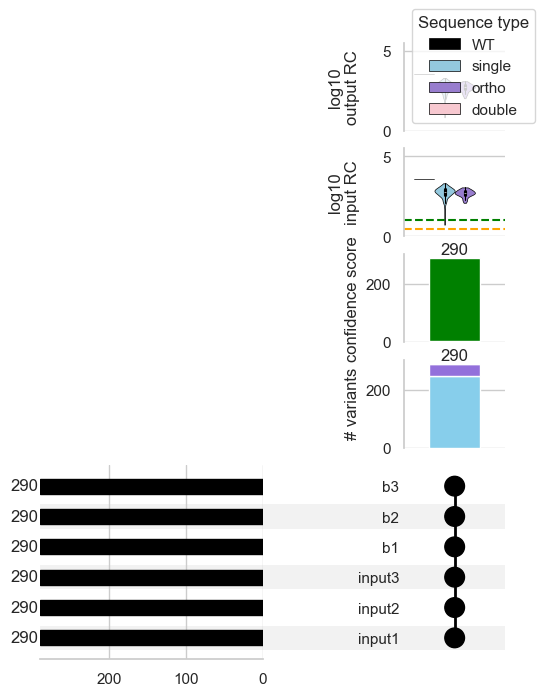

In [29]:
cov_upset[conditions] = cov_upset[conditions].astype(bool)
seq_types = ['WT', 'single', 'ortho', 'double']
seq_type_colors = ['black', 'skyblue', 'mediumpurple', 'pink']
cscores = [1,2,3]
cscore_colors = ['green','orange','red']

if pool_type == 'single':
    min_sub = 3
else:
    min_sub = 100

fig = plt.figure(figsize=(6, 8))
upset_obj = UpSet(from_indicators(conditions, data=cov_upset),
                   #show_percentages=True,
                   show_counts=True,
                   min_subset_size=min_sub,
                   sort_by='cardinality',
                   element_size=None,
                   intersection_plot_elements=0, # height of intersection barplot in matrix elements
                   totals_plot_elements = 2 # width of totals barplot in matrix elements
                  )

upset_obj.add_stacked_bars(by='seq_type',
                           colors=dict(zip(seq_types, seq_type_colors)),
                           elements=3
                          )

upset_obj.add_stacked_bars(by='confidence_score',
                           colors=dict(zip(cscores, cscore_colors)),
                           elements=3
                          )

upset_obj.add_catplot(value='mean_input', kind='violin', cut=0, density_norm='count',
                      hue='seq_type', hue_order=seq_types, palette=seq_type_colors,
                      linewidth=0.5,
                      elements=3 # height in number of matrix elements
                      )

upset_obj.add_catplot(value='mean_output', kind='violin', cut=0, density_norm='count',
                      hue='seq_type', hue_order=seq_types, palette=seq_type_colors,
                      linewidth=0.5,
                      elements=3 # height in number of matrix elements
                      )

d = upset_obj.plot(fig=fig) # Assigns all plots to a dictionary containing axes subplots - same keys as gridspec returned by upset_obj.make_grid()
ax0 = d['extra0'] # Key corresponding to 1st stacked barplot - type of sequence ('intersections' = intersection barplot)
ax1 = d['extra1'] # Key corresponding to 2nd stacked barplot (confidence score)
ax2 = d['extra2'] # Key corresponding to 1st catplot - read count for input samples
ax3 = d['extra3'] # Key corresponding to 2nd catplot - read count for output samples
ax0.legend().remove()
ax0.set_ylabel('# variants') # (unique nucleotide sequences)

ax1.legend().remove()
ax1.set_ylabel('confidence score')

ax2.legend().remove()
ax2.set(ylim=(0,5.5))
ax2.set_ylabel('log10\ninput RC')
ax2.axhline(y=np.log10(min_input_readcount_mid), linestyle='--', color=cscore_colors[1])
ax2.axhline(y=np.log10(min_input_readcount_high), linestyle='--', color=cscore_colors[0])

ax3.set(ylim=(0,5.5))
ax3.set_ylabel('log10\noutput RC')
ax3.legend(title='Sequence type')

plt.savefig(graph_outpath+cset_name+'/upset_variants_rc.svg', format='svg', dpi=300)

In [30]:
totrc = covereddf.groupby('nt_seq')[conditions].first().sum(axis=0).to_frame('total_readcount')
totrc['WT'] = covereddf[covereddf.WT==True][conditions].squeeze()
totrc['WT_%'] = 100*round(totrc['WT'] / totrc['total_readcount'], 3)
totrc['single_mut_readcount'] = covereddf[covereddf.seq_type=='single'].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['single_mut_readcount_%'] = 100*round(totrc['single_mut_readcount'] / totrc['total_readcount'], 3)
totrc['ortho_mut_readcount'] = covereddf[covereddf.seq_type=='ortho'].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['ortho_mut_readcount_%'] = 100*round(totrc['ortho_mut_readcount'] / totrc['total_readcount'], 3)
totrc['double_mut_readcount'] = covereddf[covereddf.seq_type=='double'].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['double_mut_readcount_%'] = 100*round(totrc['double_mut_readcount'] / totrc['total_readcount'], 3)
        
# Export summary - unexpected variants can have arisen through sequencing errors
totrc.to_csv(processed_data_outpath+cset_name+'/readcount_per_library.csv')
totrc

,total_readcount,WT,WT_%,single_mut_readcount,single_mut_readcount_%,ortho_mut_readcount,ortho_mut_readcount_%,double_mut_readcount,double_mut_readcount_%
input1,172973.0,3083.0,1.8,148059.0,85.6,21831.0,12.6,0.0,0.0
input2,192253.0,3910.0,2.0,169551.0,88.2,18792.0,9.8,0.0,0.0
input3,230160.0,4461.0,1.9,200358.0,87.1,25341.0,11.0,0.0,0.0
b1,142313.0,2514.0,1.8,120987.0,85.0,18812.0,13.2,0.0,0.0
b2,237480.0,4445.0,1.9,206836.0,87.1,26199.0,11.0,0.0,0.0
b3,189551.0,3456.0,1.8,164560.0,86.8,21535.0,11.4,0.0,0.0


The following is particularly important.

We add 1 read to all read counts to not have any null values (because of the dataframe's wide format).

Later on, when the selection coefficient is calculated, a zero could either mean that:

1. the sequence wasn't in the pool at t0
2. the sequence was in the pool at t0 but was not sequenced because of a low coverage
3. the sequence was so deleterious upon selective pressure that it is no longer sequenced at later timepoints

In [31]:
#pd.set_option('mode.chained_assignment', None) # Disable settingWithCopy warning
covereddf[conditions] += 1
covereddf[conditions]

,input1,input2,input3,b1,b2,b3
0,3084.0,3911.0,4462.0,2515.0,4446.0,3457.0
1,783.0,827.0,1078.0,644.0,1060.0,799.0
2,634.0,730.0,885.0,487.0,822.0,620.0
3,806.0,834.0,899.0,604.0,924.0,732.0
4,774.0,876.0,1044.0,553.0,1084.0,818.0
...,...,...,...,...,...,...
478,578.0,490.0,647.0,497.0,680.0,531.0
479,578.0,490.0,647.0,497.0,680.0,531.0
480,578.0,490.0,647.0,497.0,680.0,531.0
481,578.0,490.0,647.0,497.0,680.0,531.0


### Calculate frequencies (relative abundance of each variant)

In [32]:
abund = covereddf[conditions].div(covereddf.groupby('nt_seq')[conditions].first().sum(axis=0), axis=1)
abund.rename(columns=lambda x: x+'_abundance', inplace=True)
abund_conditions = [x+'_abundance' for x in conditions]

# Abundance values are added as columns on the existing dataframe
abundf = pd.concat([covereddf, abund], axis=1)
        
# Export dataframe
abundf.to_csv(processed_data_outpath+cset_name+'/abundance_all_libraries.csv')
#>>>>> DATAFRAME TO VISUALIZE DISTRIBUTION OF FREQUENCIES
abundf[abund_conditions]

,input1_abundance,input2_abundance,input3_abundance,b1_abundance,b2_abundance,b3_abundance
0,0.017800,0.020312,0.019362,0.017636,0.018699,0.018210
1,0.004519,0.004295,0.004678,0.004516,0.004458,0.004209
2,0.003659,0.003791,0.003840,0.003415,0.003457,0.003266
3,0.004652,0.004331,0.003901,0.004236,0.003886,0.003856
4,0.004467,0.004550,0.004530,0.003878,0.004559,0.004309
...,...,...,...,...,...,...
478,0.003336,0.002545,0.002808,0.003485,0.002860,0.002797
479,0.003336,0.002545,0.002808,0.003485,0.002860,0.002797
480,0.003336,0.002545,0.002808,0.003485,0.002860,0.002797
481,0.003336,0.002545,0.002808,0.003485,0.002860,0.002797


### Visualize distribution of frequencies

#### Convert to log10

In [33]:
log10_conditions = [x.replace('abundance', 'log10') for x in abund_conditions]
abundf[log10_conditions] = abundf[abund_conditions].transform(func='log10')

#### Conditions --> long format

In [34]:
abundlong = pd.melt(abundf.groupby(['nt_seq', 'seq_type'])[log10_conditions].first().reset_index(),
                    id_vars=['nt_seq','seq_type'], value_vars=log10_conditions, var_name='sample_id', value_name='abundance')
abundlong

,nt_seq,seq_type,sample_id,abundance
0,aagatactgtcactaagagatcca,single,input1_log10,-2.250593
1,aatatactgtcactaagagatcca,single,input1_log10,-2.349965
2,acgatactgtcactaagagatcca,single,input1_log10,-2.178764
3,actatactgtcactaagagatcca,single,input1_log10,-2.395473
4,aggatactgtcactaagagatcca,single,input1_log10,-2.786919
...,...,...,...,...
1735,ttggttttgtctttgagagatcca,ortho,b3_log10,-3.076993
1736,ttgtctttgtctttgagagatcca,ortho,b3_log10,-2.443334
1737,ttgtctttgtcttttagagatcca,ortho,b3_log10,-2.602612
1738,ttgttgttgccattgggtgaacca,ortho,b3_log10,-2.417453


/home/rodur28/anaconda3/envs/dms-env/lib/python3.11/site-packages/seaborn/utils.py:493: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/tmp/ipykernel_21943/3281301397.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels([x.split('_')[0] for x in abundlong.sample_id.unique()])


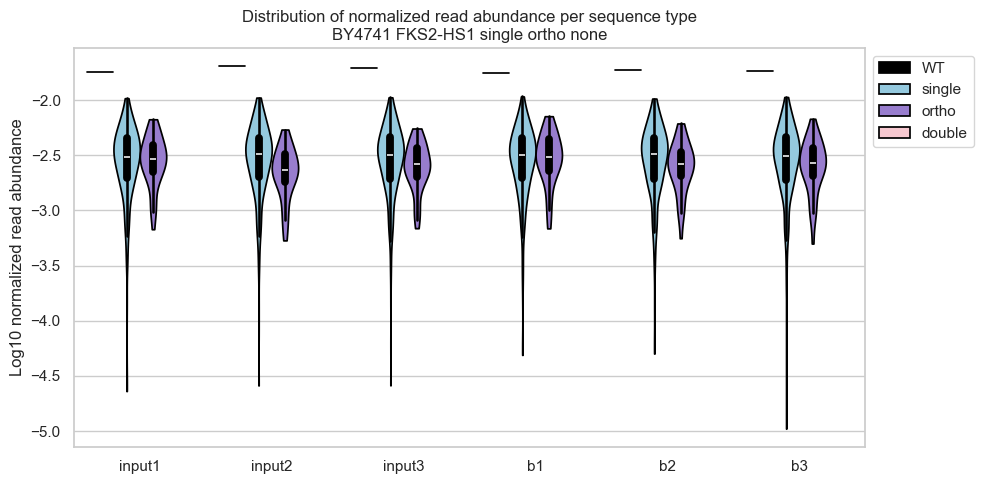

In [35]:
# Purge graph space
sns.set(rc = {'figure.figsize':(10,5)})
sns.set_theme(style='whitegrid')
f, ax = plt.subplots()

# Generate graph
fig = sns.violinplot(data=abundlong, x='sample_id', y='abundance',
                     hue='seq_type', hue_order=['WT', 'single', 'ortho', 'double'], palette=['black', 'skyblue', 'mediumpurple', 'pink'],
                     cut=0, # To make sure violins do not extend past the value range (because of log scale)
                     density_norm='count') # Width of violin proportional to number of observations

# Move legend
handles, labels = fig.get_legend_handles_labels()
sns.move_legend(fig, bbox_to_anchor=(1, 1), loc='upper left', title=None, frameon=True, handles=handles, labels=labels)

fig.axes.set(xlabel='', ylabel='Log10 normalized read abundance')
fig.set_xticklabels([x.split('_')[0] for x in abundlong.sample_id.unique()])
plt.title('Distribution of normalized read abundance per sequence type'+
         '\n'+' '.join(cset))
plt.tight_layout()

# Save graph to outpath
plt.savefig(graph_outpath+cset_name+'/abundance_distri.svg', format='svg', dpi=300)

### Add alt aminoacid and mutation type (synonymous / non-synonymous)

In [36]:
def get_mutation_type(alt, wt_aa, pos):
    if alt == wt_aa[int(pos)]:
        return 'synonymous'
    elif alt == '*':
        return 'stop'
    else:
        return 'non-synonymous'

In [37]:
abundf['alt_aa'] = abundf[abundf.seq_type != 'WT'].apply(lambda row: row['aa_seq'][int(row['aa_pos'])], axis=1)
abundf['mutation_type'] = abundf[abundf.seq_type != 'WT'].apply(lambda row: get_mutation_type(row.alt_aa, wtaa, row.aa_pos), axis=1)
abundf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,b2_abundance,b3_abundance,input1_log10,input2_log10,input3_log10,b1_log10,b2_log10,b3_log10,alt_aa,mutation_type
0,WT,ctaatactgtcactaagagatcca,NaN,NaN,NaN,NaN,LILSLRDP,True,False,False,...,0.018699,0.018210,-1.749591,-1.692240,-1.713047,-1.753591,-1.728188,-1.739691,NaN,NaN
1,single,tttatactgtcactaagagatcca,0.0,ttt,1.0,NaN,FILSLRDP,<NA>,False,False,...,0.004458,0.004209,-2.344944,-2.367022,-2.329958,-2.345243,-2.350851,-2.375843,F,non-synonymous
2,single,ttgatactgtcactaagagatcca,0.0,ttg,1.0,NaN,LILSLRDP,<NA>,False,False,...,0.003457,0.003266,-2.436617,-2.421205,-2.415633,-2.466600,-2.461285,-2.485998,L,synonymous
3,single,cttatactgtcactaagagatcca,0.0,ctt,1.0,NaN,LILSLRDP,<NA>,False,False,...,0.003886,0.003856,-2.332371,-2.363362,-2.408817,-2.373092,-2.410485,-2.413879,L,synonymous
4,single,ctgatactgtcactaagagatcca,0.0,ctg,1.0,NaN,LILSLRDP,<NA>,False,False,...,0.004559,0.004309,-2.349965,-2.342024,-2.343876,-2.411404,-2.341128,-2.365637,L,synonymous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,ortho,ttgactttgtcttttaaagatcca,1.0,act,2.0,NaN,LTLSFKDP,<NA>,False,False,...,0.002860,0.002797,-2.476778,-2.594332,-2.551672,-2.457772,-2.543648,-2.553295,T,non-synonymous
479,ortho,ttgactttgtcttttaaagatcca,2.0,ttg,3.0,NaN,LTLSFKDP,<NA>,False,False,...,0.002860,0.002797,-2.476778,-2.594332,-2.551672,-2.457772,-2.543648,-2.553295,L,synonymous
480,ortho,ttgactttgtcttttaaagatcca,3.0,tct,4.0,NaN,LTLSFKDP,<NA>,False,False,...,0.002860,0.002797,-2.476778,-2.594332,-2.551672,-2.457772,-2.543648,-2.553295,S,synonymous
481,ortho,ttgactttgtcttttaaagatcca,4.0,ttt,5.0,NaN,LTLSFKDP,<NA>,False,False,...,0.002860,0.002797,-2.476778,-2.594332,-2.551672,-2.457772,-2.543648,-2.553295,F,non-synonymous


### Duplicate WT abundance for each position

In [38]:
# Turn WT sequence into list of codons with 0-based position
codcoord = [(i//3,wtseq[i:i+3]) for i in range(0,len(wtseq),3)]
print(codcoord)

[(0, 'cta'), (1, 'ata'), (2, 'ctg'), (3, 'tca'), (4, 'cta'), (5, 'aga'), (6, 'gat'), (7, 'cca')]


In [39]:
# We create a custom list of columns to create a dataframe with WT codons
wtdf_cols = ['aa_pos', 'alt_codons', 'alt_aa', 'seq_type', 'mutation_type', 'WT', 'nt_seq', 'aa_seq', 'Nham_aa', 'confidence_score']

In [40]:
# A dataframe is created with 1 row per WT codon
pos_df = pd.DataFrame([[a, codcoord[a][1], wtaa[a], 'WT', 'synonymous', True, wtseq, wtaa, 0, abundf.loc[abundf.WT, 'confidence_score'][0]]
                       for a in range(0,len(wtaa))], columns=wtdf_cols)
for a in abund_conditions:
    pos_df[a] = abundf.loc[abundf.WT, a].values[0]
pos_df  

,aa_pos,alt_codons,alt_aa,seq_type,mutation_type,WT,nt_seq,aa_seq,Nham_aa,confidence_score,input1_abundance,input2_abundance,input3_abundance,b1_abundance,b2_abundance,b3_abundance
0,0,cta,L,WT,synonymous,True,ctaatactgtcactaagagatcca,LILSLRDP,0,1.0,0.0178,0.020312,0.019362,0.017636,0.018699,0.01821
1,1,ata,I,WT,synonymous,True,ctaatactgtcactaagagatcca,LILSLRDP,0,1.0,0.0178,0.020312,0.019362,0.017636,0.018699,0.01821
2,2,ctg,L,WT,synonymous,True,ctaatactgtcactaagagatcca,LILSLRDP,0,1.0,0.0178,0.020312,0.019362,0.017636,0.018699,0.01821
3,3,tca,S,WT,synonymous,True,ctaatactgtcactaagagatcca,LILSLRDP,0,1.0,0.0178,0.020312,0.019362,0.017636,0.018699,0.01821
4,4,cta,L,WT,synonymous,True,ctaatactgtcactaagagatcca,LILSLRDP,0,1.0,0.0178,0.020312,0.019362,0.017636,0.018699,0.01821
5,5,aga,R,WT,synonymous,True,ctaatactgtcactaagagatcca,LILSLRDP,0,1.0,0.0178,0.020312,0.019362,0.017636,0.018699,0.01821
6,6,gat,D,WT,synonymous,True,ctaatactgtcactaagagatcca,LILSLRDP,0,1.0,0.0178,0.020312,0.019362,0.017636,0.018699,0.01821
7,7,cca,P,WT,synonymous,True,ctaatactgtcactaagagatcca,LILSLRDP,0,1.0,0.0178,0.020312,0.019362,0.017636,0.018699,0.01821


In [41]:
withSyndf = pd.concat([abundf[abundf.WT.isnull()], pos_df], ignore_index=True)
withSyndf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,b2_abundance,b3_abundance,input1_log10,input2_log10,input3_log10,b1_log10,b2_log10,b3_log10,alt_aa,mutation_type
0,single,tttatactgtcactaagagatcca,0.0,ttt,1.0,NaN,FILSLRDP,<NA>,False,False,...,0.004458,0.004209,-2.344944,-2.367022,-2.329958,-2.345243,-2.350851,-2.375843,F,non-synonymous
1,single,ttgatactgtcactaagagatcca,0.0,ttg,1.0,NaN,LILSLRDP,<NA>,False,False,...,0.003457,0.003266,-2.436617,-2.421205,-2.415633,-2.466600,-2.461285,-2.485998,L,synonymous
2,single,cttatactgtcactaagagatcca,0.0,ctt,1.0,NaN,LILSLRDP,<NA>,False,False,...,0.003886,0.003856,-2.332371,-2.363362,-2.408817,-2.373092,-2.410485,-2.413879,L,synonymous
3,single,ctgatactgtcactaagagatcca,0.0,ctg,1.0,NaN,LILSLRDP,<NA>,False,False,...,0.004559,0.004309,-2.349965,-2.342024,-2.343876,-2.411404,-2.341128,-2.365637,L,synonymous
4,single,attatactgtcactaagagatcca,0.0,att,1.0,NaN,IILSLRDP,<NA>,False,False,...,0.002692,0.003118,-2.552070,-2.582097,-2.591725,-2.535035,-2.569977,-2.506068,I,non-synonymous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,WT,ctaatactgtcactaagagatcca,3.0,tca,NaN,NaN,LILSLRDP,True,NaN,NaN,...,0.018699,0.018210,NaN,NaN,NaN,NaN,NaN,NaN,S,synonymous
486,WT,ctaatactgtcactaagagatcca,4.0,cta,NaN,NaN,LILSLRDP,True,NaN,NaN,...,0.018699,0.018210,NaN,NaN,NaN,NaN,NaN,NaN,L,synonymous
487,WT,ctaatactgtcactaagagatcca,5.0,aga,NaN,NaN,LILSLRDP,True,NaN,NaN,...,0.018699,0.018210,NaN,NaN,NaN,NaN,NaN,NaN,R,synonymous
488,WT,ctaatactgtcactaagagatcca,6.0,gat,NaN,NaN,LILSLRDP,True,NaN,NaN,...,0.018699,0.018210,NaN,NaN,NaN,NaN,NaN,NaN,D,synonymous


### Pair input/output samples

In [42]:
input_conditions = [x for x in abund_conditions if 'input' in x]
output_conditions = [x for x in abund_conditions if x not in input_conditions]
inpoutp_tuples = [(x, y) for x in input_conditions for y in output_conditions if x.split('_')[0][-1] == y.split('_')[0][-1]]
print(inpoutp_tuples)

[('input1_abundance', 'b1_abundance'), ('input2_abundance', 'b2_abundance'), ('input3_abundance', 'b3_abundance')]


### Calculate log2 fold-change (WT=0)

In [43]:
log2FC_conditions = ['Log2FC_'+ x[0].split('_')[0][-1] for x in inpoutp_tuples]
for i, v in enumerate(log2FC_conditions):
    withSyndf[v] = withSyndf[abund_conditions].apply(lambda row: math.log2(row[inpoutp_tuples[i][1]]/row[inpoutp_tuples[i][0]]), axis=1)
withSyndf[log2FC_conditions]

,Log2FC_1,Log2FC_2,Log2FC_3
0,-0.000992,0.053719,-0.152428
1,-0.099602,-0.133144,-0.233747
2,-0.135272,-0.156541,-0.016815
3,-0.204095,0.002976,-0.072287
4,0.056586,0.040262,0.284544
...,...,...,...
485,-0.013285,-0.119416,-0.088508
486,-0.013285,-0.119416,-0.088508
487,-0.013285,-0.119416,-0.088508
488,-0.013285,-0.119416,-0.088508


### Get number of mitotic generations from experimental design file

In [44]:
designdf = pd.read_csv(expdesign_path+cset_name+'_expdesign.txt', sep='\t', header=0)
nbgen = designdf.loc[(designdf.experiment_replicate == 1) & (designdf.selection_id == 1), 'generations'].tolist()
list_replicates = designdf.loc[(designdf.experiment_replicate == 1) & (designdf.selection_id == 1), 'selection_replicate'].tolist()
repgen = [(int(list_replicates[i]), nbgen[i]) for i in range(0,len(nbgen))]
print(repgen)

[(1, 4.150390101335132), (2, 3.512385093358195), (3, 3.970746132012217)]


### Normalize log2FC with number of mitotic generations

In [45]:
for i, v in enumerate(log2FC_conditions):
    withSyndf[v] = withSyndf[v].apply(lambda x: x/repgen[i][1] if int(v[-1])==repgen[i][0] else 'error')

withSyndf[log2FC_conditions]

,Log2FC_1,Log2FC_2,Log2FC_3
0,-0.000239,0.015294,-0.038388
1,-0.023998,-0.037907,-0.058867
2,-0.032593,-0.044568,-0.004235
3,-0.049175,0.000847,-0.018205
4,0.013634,0.011463,0.071660
...,...,...,...
485,-0.003201,-0.033998,-0.022290
486,-0.003201,-0.033998,-0.022290
487,-0.003201,-0.033998,-0.022290
488,-0.003201,-0.033998,-0.022290


### Calculate median of synonymous codons

Below we show that some synonymous variants appear to have an impact.

If their proportion in the population is small enough, taking the median from what appears to be almost always bimodal should be robust enough

In [46]:
synOnly = withSyndf[(withSyndf.aa_seq == wtaa) & (withSyndf.nt_seq != wtseq)
                   ].groupby('nt_seq')[['aa_pos','alt_aa','alt_codons'] + log2FC_conditions
                                        ].first().sort_values(by=['aa_pos','alt_aa','alt_codons']).reset_index()
len(synOnly)

18

In [47]:
synLong = pd.melt(synOnly, id_vars = 'nt_seq', value_vars = log2FC_conditions, var_name='replicate', value_name='norm_log2FC')
synLong

,nt_seq,replicate,norm_log2FC
0,ctgatactgtcactaagagatcca,Log2FC_1,-0.049175
1,cttatactgtcactaagagatcca,Log2FC_1,-0.032593
2,ttgatactgtcactaagagatcca,Log2FC_1,-0.023998
3,ttgattttgtctttgagagatcca,Log2FC_1,0.063835
4,ctaattctgtcactaagagatcca,Log2FC_1,0.004772
5,ctaatactttcactaagagatcca,Log2FC_1,-0.030563
6,ctaatattgtcactaagagatcca,Log2FC_1,-0.014975
7,ctaatactgagtctaagagatcca,Log2FC_1,0.032612
8,ctaatactgtcgctaagagatcca,Log2FC_1,0.012069
9,ctaatactgtctctaagagatcca,Log2FC_1,0.006554


[Text(0.5, 0, 'log2FC / nb_gen')]

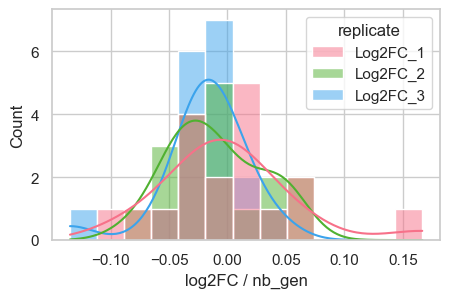

In [48]:
# Purge graph space
sns.set(rc = {'figure.figsize':(5,3)})
sns.set_theme(style='whitegrid')
f, ax = plt.subplots()

g = sns.histplot(synLong, x='norm_log2FC',
                 hue='replicate', palette='husl',
                 kde=True)

g.set(xlabel = 'log2FC / nb_gen')

In [49]:
medianSyn = synOnly[log2FC_conditions].median().squeeze()
medianSyn

Log2FC_1    0.000099
Log2FC_2   -0.017357
Log2FC_3   -0.016785
dtype: float64

### Calculate selection coefficient

In [50]:
selcoeff_conditions = [x.replace('Log2FC','selcoeff') for x in log2FC_conditions]
withSyndf[selcoeff_conditions] = withSyndf[log2FC_conditions].subtract(medianSyn, axis=1)
withSyndf[selcoeff_conditions]

,selcoeff_1,selcoeff_2,selcoeff_3
0,-0.000338,0.032651,-0.021603
1,-0.024098,-0.020550,-0.042082
2,-0.032692,-0.027211,0.012550
3,-0.049274,0.018204,-0.001420
4,0.013535,0.028820,0.088445
...,...,...,...
485,-0.003300,-0.016641,-0.005505
486,-0.003300,-0.016641,-0.005505
487,-0.003300,-0.016641,-0.005505
488,-0.003300,-0.016641,-0.005505


### Compare replicates

Note: here the dataframe is reshaped to have 1 value per nucleotide sequence, with replicates in wide format. To minimize the number of steps, the same dataframe is used to calculate the correlation coefficient (using only the selection coefficients) and to look at the distribution.

In [51]:
gby_cols = ['Nham_aa','aa_seq','nt_seq']
permut = withSyndf.groupby(gby_cols)[selcoeff_conditions].first().reset_index()
permut.columns = [x[-1] if 'selcoeff' in x else x for x in permut.columns]
permut

,Nham_aa,aa_seq,nt_seq,1,2,3
0,0.0,LILSLRDP,ctaatactgagtctaagagatcca,0.032513,0.069616,-0.017308
1,0.0,LILSLRDP,ctaatactgtcactaagagatcca,-0.003300,-0.016641,-0.005505
2,0.0,LILSLRDP,ctaatactgtcactaagagatccg,0.052292,0.017373,0.060328
3,0.0,LILSLRDP,ctaatactgtcactaagagatcct,0.166450,-0.020031,-0.117895
4,0.0,LILSLRDP,ctaatactgtcactaagggatcca,-0.093800,-0.032496,-0.003078
...,...,...,...,...,...,...
285,5.0,LTRAFRDS,ttgactagagcttttagagattct,0.020452,0.195343,0.029974
286,5.0,LTSSFSSP,ttgacttcttctttttcttctcca,0.069913,0.111372,-0.005128
287,5.0,QIRPLIAP,caaattagaccattgattgctcca,-0.012174,0.100525,0.065608
288,6.0,LTLLVTQH,ttgactttgttggttactcaacat,-0.006804,0.067968,0.022819


In [52]:
import itertools
rep_combinations = list(itertools.combinations(permut.columns[len(gby_cols):], 2))
rep_combinations

[('1', '2'), ('1', '3'), ('2', '3')]

In [53]:
from scipy import stats

pearson_dict = {}
for c in rep_combinations:
    pearson_dict[c] = stats.pearsonr(permut[c[0]], permut[c[1]])[0]
    # One possibility is to calculate this for stop, non-synonymous and synonymous separately
    # Pearson r for non-synonymous is the most important (the most affected by distribution of effects)
    # Depending on the level of noise, we could select the two lowest values, see if it's above a fixed threshold (both should be above .8)
    # then see which replicate was common to the 2 corresponding combinations and calculate the median from the two remaining
    
pearson_dict

{('1', '2'): 0.14677414947811032,
 ('1', '3'): -0.0753766938400282,
 ('2', '3'): 0.1504085574199213}

In [54]:
if len(pearson_dict)>=1:
    pearson_df = pd.DataFrame.from_dict(pearson_dict, orient='index', columns=['Pearson']).reset_index(names='rep_compared')
    pearson_df[['replicate1','replicate2']] = pd.DataFrame(pearson_df.rep_compared.to_list())
    pearson_df.to_csv(processed_data_outpath+cset_name+'/Pearson_replicates.csv')

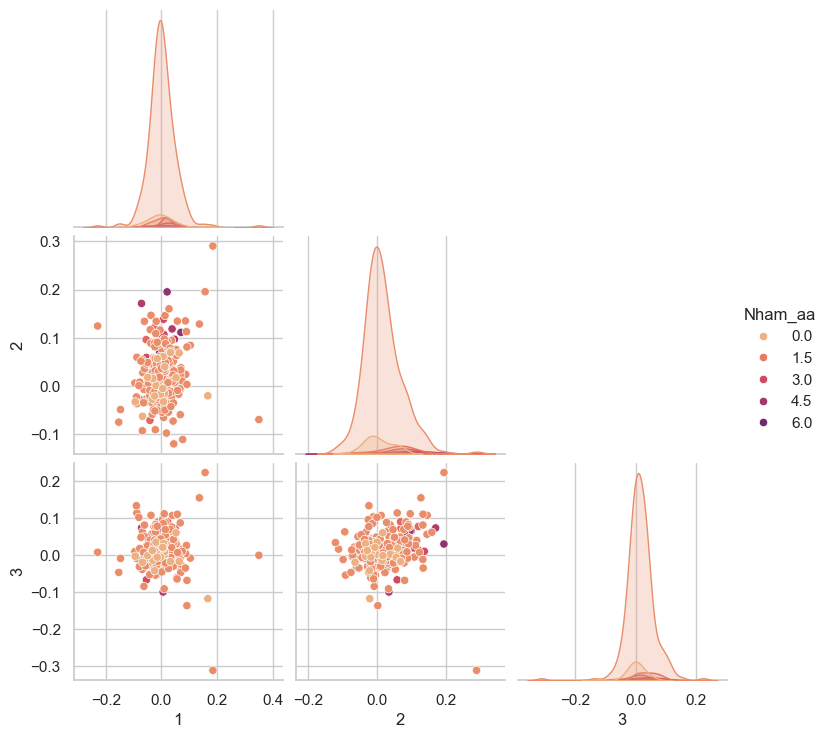

In [55]:
# Purge graph space
sns.set(rc = {'figure.figsize':(5,3)})
sns.set_theme(style='whitegrid')

fig = sns.pairplot(permut.sort_values(by='Nham_aa', ascending=False),
                   hue='Nham_aa', palette='flare',
                   corner=True)

# Code below does not work for all possible scenarios (replicate# does not necessarily match with facet#)
#for i in range(len(permut.columns[2:])):
#    for j in range(len(permut.columns[2:])):
#        if i < j:
#            fig.axes[j][i].annotate(round(pearson_dict[(str(i+1),str(j+1))],2), (-3,1))

In [56]:
permutlong = pd.melt(permut, id_vars = gby_cols, value_vars = [x[-1] for x in selcoeff_conditions], var_name='replicate', value_name='selcoeff')
permutlong

,Nham_aa,aa_seq,nt_seq,replicate,selcoeff
0,0.0,LILSLRDP,ctaatactgagtctaagagatcca,1,0.032513
1,0.0,LILSLRDP,ctaatactgtcactaagagatcca,1,-0.003300
2,0.0,LILSLRDP,ctaatactgtcactaagagatccg,1,0.052292
3,0.0,LILSLRDP,ctaatactgtcactaagagatcct,1,0.166450
4,0.0,LILSLRDP,ctaatactgtcactaagggatcca,1,-0.093800
...,...,...,...,...,...
865,5.0,LTRAFRDS,ttgactagagcttttagagattct,3,0.029974
866,5.0,LTSSFSSP,ttgacttcttctttttcttctcca,3,-0.005128
867,5.0,QIRPLIAP,caaattagaccattgattgctcca,3,0.065608
868,6.0,LTLLVTQH,ttgactttgttggttactcaacat,3,0.022819


In [57]:
permutlong_aa = permutlong.groupby(['Nham_aa','aa_seq','replicate'])[['selcoeff']].median().reset_index()
permutlong_aa

,Nham_aa,aa_seq,replicate,selcoeff
0,0.0,LILSLRDP,1,-0.003300
1,0.0,LILSLRDP,2,-0.001205
2,0.0,LILSLRDP,3,-0.001420
3,1.0,*ILSLRDP,1,-0.001275
4,1.0,*ILSLRDP,2,0.022510
...,...,...,...,...
562,6.0,LTLLVTQH,2,0.067968
563,6.0,LTLLVTQH,3,0.022819
564,7.0,QVKPMIKP,1,0.031266
565,7.0,QVKPMIKP,2,0.039735


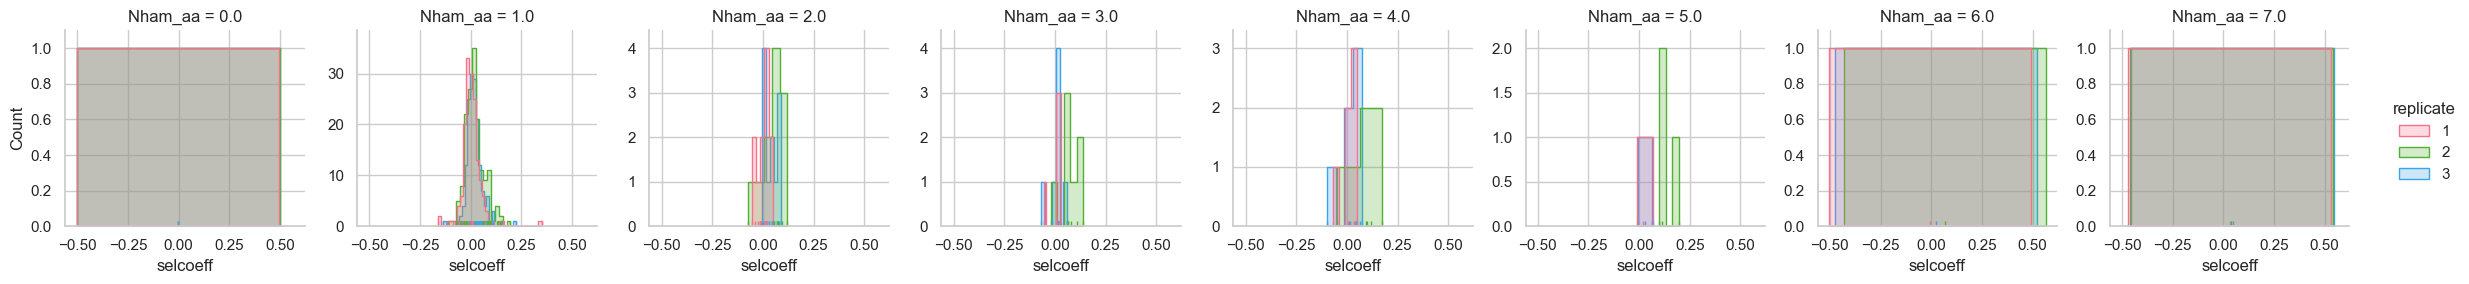

In [58]:
# Purge graph space
sns.set(rc = {'figure.figsize':(5,3)})
sns.set_theme(style='whitegrid')

fig = sns.displot(permutlong_aa, x='selcoeff', col = 'Nham_aa',
                  hue='replicate', palette='husl', rug=True,
                  element='step', common_norm=False,
                  common_bins=False, facet_kws={'sharex': True, 'sharey': False}, # different y scales for each facet
                  height=3
                 )

### Drop replicate if uncorrelated

#### ⚠️ **Filtering step** ⚠️

In [59]:
pearson_lowest = sorted(pearson_dict.items(), key=lambda x:x[1])
if (len(pearson_lowest) == 3) & (compound in ['caspofungin','micafungin','anidulafungin']):
    if (pearson_lowest[0][1] < .8) & (pearson_lowest[1][1] < .8):
        selcoeff_conditions.remove(f'selcoeff_{"".join(set(pearson_lowest[0][0]) & set(pearson_lowest[1][0]))}')

### Calculate median selection coefficient

In [60]:
withSyndf['median_s'] = withSyndf[selcoeff_conditions].median(axis=1)
withSyndf[selcoeff_conditions+['median_s']]

,selcoeff_1,selcoeff_2,selcoeff_3,median_s
0,-0.000338,0.032651,-0.021603,-0.000338
1,-0.024098,-0.020550,-0.042082,-0.024098
2,-0.032692,-0.027211,0.012550,-0.027211
3,-0.049274,0.018204,-0.001420,-0.001420
4,0.013535,0.028820,0.088445,0.028820
...,...,...,...,...
485,-0.003300,-0.016641,-0.005505,-0.005505
486,-0.003300,-0.016641,-0.005505,-0.005505
487,-0.003300,-0.016641,-0.005505,-0.005505
488,-0.003300,-0.016641,-0.005505,-0.005505


### Export dataframe

In [61]:
withSyndf.to_csv(processed_data_outpath+cset_name+'/selcoeff_all_libraries.csv')

### Visualize single mutants as heatmap (codon level)

In [62]:
if pool_type == 'single':
    withWTdf = withSyndf[withSyndf.seq_type.isin(['WT','single'])]
else:
    withWTdf = withSyndf[withSyndf.Nham_aa <=1]
withWTdf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,b3_log10,alt_aa,mutation_type,Log2FC_1,Log2FC_2,Log2FC_3,selcoeff_1,selcoeff_2,selcoeff_3,median_s
0,single,tttatactgtcactaagagatcca,0.0,ttt,1.0,NaN,FILSLRDP,<NA>,False,False,...,-2.375843,F,non-synonymous,-0.000239,0.015294,-0.038388,-0.000338,0.032651,-0.021603,-0.000338
1,single,ttgatactgtcactaagagatcca,0.0,ttg,1.0,NaN,LILSLRDP,<NA>,False,False,...,-2.485998,L,synonymous,-0.023998,-0.037907,-0.058867,-0.024098,-0.020550,-0.042082,-0.024098
2,single,cttatactgtcactaagagatcca,0.0,ctt,1.0,NaN,LILSLRDP,<NA>,False,False,...,-2.413879,L,synonymous,-0.032593,-0.044568,-0.004235,-0.032692,-0.027211,0.012550,-0.027211
3,single,ctgatactgtcactaagagatcca,0.0,ctg,1.0,NaN,LILSLRDP,<NA>,False,False,...,-2.365637,L,synonymous,-0.049175,0.000847,-0.018205,-0.049274,0.018204,-0.001420,-0.001420
4,single,attatactgtcactaagagatcca,0.0,att,1.0,NaN,IILSLRDP,<NA>,False,False,...,-2.506068,I,non-synonymous,0.013634,0.011463,0.071660,0.013535,0.028820,0.088445,0.028820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,WT,ctaatactgtcactaagagatcca,3.0,tca,NaN,NaN,LILSLRDP,True,NaN,NaN,...,NaN,S,synonymous,-0.003201,-0.033998,-0.022290,-0.003300,-0.016641,-0.005505,-0.005505
486,WT,ctaatactgtcactaagagatcca,4.0,cta,NaN,NaN,LILSLRDP,True,NaN,NaN,...,NaN,L,synonymous,-0.003201,-0.033998,-0.022290,-0.003300,-0.016641,-0.005505,-0.005505
487,WT,ctaatactgtcactaagagatcca,5.0,aga,NaN,NaN,LILSLRDP,True,NaN,NaN,...,NaN,R,synonymous,-0.003201,-0.033998,-0.022290,-0.003300,-0.016641,-0.005505,-0.005505
488,WT,ctaatactgtcactaagagatcca,6.0,gat,NaN,NaN,LILSLRDP,True,NaN,NaN,...,NaN,D,synonymous,-0.003201,-0.033998,-0.022290,-0.003300,-0.016641,-0.005505,-0.005505


#### Pivot and sort by aminoacid (properties) and codon (alphabetical)

In [63]:
codon_table = pd.read_csv(codon_table_path, header=0)
codon_table['codon'] = codon_table['codon'].str.lower()
codon_table.sort_values(by='codon', inplace=True)
list_codons = codon_table.codon.unique()
cod_sort_dic = dict(zip(list_codons, list(range(0, len(list_codons)))))

aa_sort_order = '*PGCQNTSEDKHRWYFMLIVA'
aa_sort_dic = dict(zip(list(aa_sort_order), list(range(0,len(aa_sort_order)))))

aa_sort_dic.update(cod_sort_dic)

In [64]:
if pool_type == 'single':
    wide_single = withWTdf.pivot(index=['alt_aa','alt_codons'], columns='aa_pos', values='median_s')
    wide_single.sort_index(key=lambda x: x.map(aa_sort_dic), inplace=True)

#### Generate heatmap

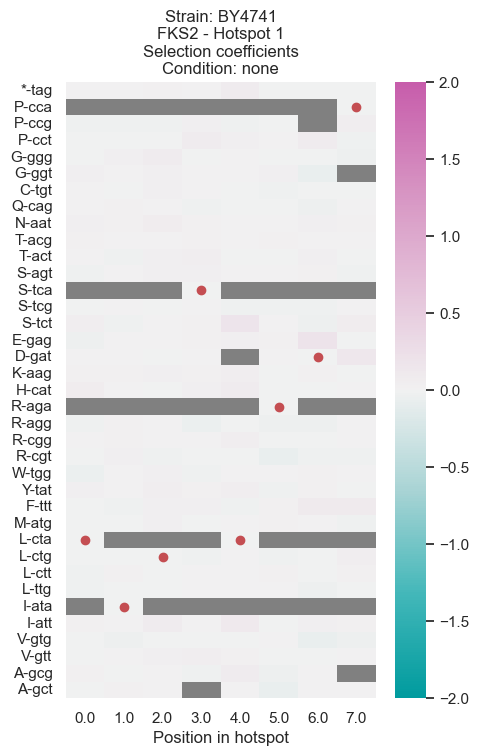

In [65]:
if pool_type == 'single':
    # Purge graph space
    sns.set(rc = {'figure.figsize':(5,8)})
    sns.set_theme(style='white')
    f, ax = plt.subplots()
    
    # Custom color palette
    ccmap = sns.color_palette("blend:#009B9E,#42B7B9,#A7D3D4,#F1F1F1,#E4C1D9,#D691C1,#C75DAB", # CARTOColors Tropic
                              as_cmap=True)
    ccmap.set_bad('.5') # Color for missing values
    
    # Mask for missing values
    mask = pd.isnull(wide_single)
    
    # Draw heatmap
    ax = sns.heatmap(wide_single, mask=mask,
                     cmap=ccmap, center = 0,
                     vmin=-2, vmax=2)
    ax.set_xlabel('Position in hotspot')
    ax.set_ylabel(None)
    ax.set_title('Strain: '+strain+
                 '\n'+locus[:4]+' - Hotspot '+locus[-1]+
                 '\nSelection coefficients'+
                 '\nCondition: '+compound)

    # Coordinates of WT codons on the heatmap are extracted from the dataframe
    # Coordinates should be OK even if some codons are missing from the dataframe
    codon_list = [x[1] for x in wide_single.index]
    wtcoord = [((i//3)+0.5,codon_list.index(wtseq[i:i+3])+0.5) for i in range(0,len(wtseq),3)]

    for o in wtcoord:
        ax.plot(o[0],o[1],'or') # displays WT codons by marking them with red (r) circles (o)

    # Graphs are output in the specified folder
    plt.savefig(graph_outpath+cset_name+'/nt_heatmap_median_s.svg', format='svg', dpi=300)

### Aggregate at protein level

### Visualize single mutants as heatmap (protein level)

In [66]:
withWTdf_gby = withWTdf.groupby(['alt_aa','aa_pos','nt_seq'])[['median_s']].first().reset_index()

In [67]:
aa_single = withWTdf_gby.groupby(['alt_aa','aa_pos'])[['median_s']].median().reset_index()
wide_aa = aa_single.pivot(index='alt_aa', columns='aa_pos', values='median_s')
wide_aa.sort_index(key=lambda x: x.map(aa_sort_dic), inplace=True)
wide_aa

aa_pos,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
alt_aa,,,,,,,,
*,0.004193,0.011840,0.030179,0.000275,0.083059,-0.007054,-0.009431,-0.004179
P,-0.012795,-0.009020,-0.016682,0.060541,0.011646,0.003942,0.084600,-0.005505
G,0.015796,0.021563,0.062914,0.000765,0.009938,0.016796,-0.037302,-0.034768
C,0.014597,-0.010237,0.041109,0.010587,-0.000406,-0.018214,-0.004593,-0.007053
Q,0.005204,0.019883,0.002203,-0.029141,-0.012785,-0.014763,-0.033019,0.014008
N,0.038079,0.027584,0.076216,0.022221,0.006609,0.007062,0.042628,0.027251
T,0.016361,-0.010711,0.023918,0.035715,-0.002174,0.003247,0.021803,-0.000172
S,-0.012586,0.001740,0.002790,0.015481,0.001154,0.000960,-0.016133,0.014693
E,-0.036345,0.000488,0.006455,0.016212,0.032417,0.023420,0.195581,-0.003442


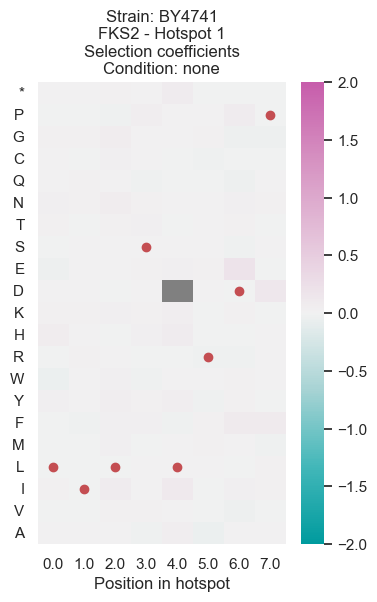

In [68]:
# Purge graph space
sns.set(rc = {'figure.figsize':(4,6),
             })
sns.set_theme(style='white')
f, ax = plt.subplots()

# Custom color palette
ccmap = sns.color_palette("blend:#009B9E,#42B7B9,#A7D3D4,#F1F1F1,#E4C1D9,#D691C1,#C75DAB", # CARTOColors Tropic
                          as_cmap=True)
ccmap.set_bad('.5') # Color for missing values

# Mask for missing values
mask = pd.isnull(wide_aa)

# Draw heatmap
ax = sns.heatmap(wide_aa, mask=mask, 
                 cmap=ccmap, center = 0,
                 vmin=-2,
                 vmax=2
                )
ax.set_xlabel('Position in hotspot')
ax.set_ylabel(None)
plt.yticks(rotation=0)
ax.set_title('Strain: '+strain+
             '\n'+locus[:4]+' - Hotspot '+locus[-1]+
             '\nSelection coefficients'+
             '\nCondition: '+compound)

# Coordinates of WT protein sequence on the heatmap are extracted from the dataframe
# Coordinates should be OK even if the dataframe contains missing values
wtcoord_aa = [(i+0.5, list(aa_sort_order).index(v)+0.5) for i,v in enumerate(wtaa)]

for o in wtcoord_aa:
    ax.plot(o[0],o[1],'or') # displays WT codons by marking them with red (r) circles (o)
    
# Graphs are output in the specified folder
plt.savefig(graph_outpath+cset_name+'/aa_heatmap_median_s.svg', format='svg', dpi=300)

### Compare with DiMSum-corrected fitness values

For some samples, there was no fitness values calculated by DiMSum. There's no easy way to solve this until [this PR](https://github.com/nteract/papermill/pull/738) moves forward. Which means I have to put an if upstream of every following cell.

In [69]:
dimsum_fpath = f'{dimsumfitness_path}/fitness_{pool_type}s_{cset_name}.txt'
if os.path.exists(dimsum_fpath):
    dimsum = pd.read_csv(dimsum_fpath, sep=' ')
    display(dimsum)

,Pos,WT_AA,Mut,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma
0,1,L,K,NaN,KILSLRDP,NaN,1,NaN,False,False,1159.666667,0.015916,0.013366
1,1,L,N,NaN,NILSLRDP,NaN,1,NaN,False,False,861.333333,0.038029,0.014873
2,1,L,T,NaN,TILSLRDP,NaN,1,NaN,False,False,2193.000000,0.018842,0.010608
3,1,L,R,NaN,RILSLRDP,NaN,1,NaN,False,False,1816.000000,0.023345,0.011611
4,1,L,S,NaN,SILSLRDP,NaN,1,NaN,False,False,2481.333333,0.015234,0.010231
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,1,L,*,NaN,*ILSLRDP,NaN,1,NaN,True,False,1620.333333,0.011594,0.011911
154,1,L,Y,NaN,YILSLRDP,NaN,1,NaN,False,False,1024.666667,0.044128,0.013961
155,1,L,W,NaN,WILSLRDP,NaN,1,NaN,False,False,806.000000,-0.068195,0.015666
156,1,L,C,NaN,CILSLRDP,NaN,1,NaN,False,False,721.000000,0.016743,0.016034


In [70]:
if os.path.exists(dimsum_fpath):
    if pool_type == 'single':
        dimsum_long = dimsum
        dimsum_long['mutated_codon'] = 1
    else:
        dimsum_long = pd.wide_to_long(dimsum,
                                      stubnames = ['Pos', 'WT_AA', 'Mut', 'fitness', 'sigma'],
                                      i = ['aa_seq','Nham_aa','mean_count','fitness_uncorr','sigma_uncorr'],
                                      j = 'mutated_codon').reset_index()
    display(dimsum_long)

,Pos,WT_AA,Mut,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma,mutated_codon
0,1,L,K,NaN,KILSLRDP,NaN,1,NaN,False,False,1159.666667,0.015916,0.013366,1
1,1,L,N,NaN,NILSLRDP,NaN,1,NaN,False,False,861.333333,0.038029,0.014873,1
2,1,L,T,NaN,TILSLRDP,NaN,1,NaN,False,False,2193.000000,0.018842,0.010608,1
3,1,L,R,NaN,RILSLRDP,NaN,1,NaN,False,False,1816.000000,0.023345,0.011611,1
4,1,L,S,NaN,SILSLRDP,NaN,1,NaN,False,False,2481.333333,0.015234,0.010231,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,1,L,*,NaN,*ILSLRDP,NaN,1,NaN,True,False,1620.333333,0.011594,0.011911,1
154,1,L,Y,NaN,YILSLRDP,NaN,1,NaN,False,False,1024.666667,0.044128,0.013961,1
155,1,L,W,NaN,WILSLRDP,NaN,1,NaN,False,False,806.000000,-0.068195,0.015666,1
156,1,L,C,NaN,CILSLRDP,NaN,1,NaN,False,False,721.000000,0.016743,0.016034,1


In [71]:
if os.path.exists(dimsum_fpath):
    dimsum_long.rename(columns={'Pos':'aa_pos', 'Mut':'alt_aa'}, inplace=True)
    dimsum_long['aa_pos']-=1
    display(dimsum_long)

,aa_pos,WT_AA,alt_aa,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma,mutated_codon
0,0,L,K,NaN,KILSLRDP,NaN,1,NaN,False,False,1159.666667,0.015916,0.013366,1
1,0,L,N,NaN,NILSLRDP,NaN,1,NaN,False,False,861.333333,0.038029,0.014873,1
2,0,L,T,NaN,TILSLRDP,NaN,1,NaN,False,False,2193.000000,0.018842,0.010608,1
3,0,L,R,NaN,RILSLRDP,NaN,1,NaN,False,False,1816.000000,0.023345,0.011611,1
4,0,L,S,NaN,SILSLRDP,NaN,1,NaN,False,False,2481.333333,0.015234,0.010231,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,0,L,*,NaN,*ILSLRDP,NaN,1,NaN,True,False,1620.333333,0.011594,0.011911,1
154,0,L,Y,NaN,YILSLRDP,NaN,1,NaN,False,False,1024.666667,0.044128,0.013961,1
155,0,L,W,NaN,WILSLRDP,NaN,1,NaN,False,False,806.000000,-0.068195,0.015666,1
156,0,L,C,NaN,CILSLRDP,NaN,1,NaN,False,False,721.000000,0.016743,0.016034,1


In [72]:
if os.path.exists(dimsum_fpath):
    ntdf = withSyndf[withSyndf.Nham_aa == nhamaa 
    ].groupby(['aa_seq','mutated_codon','Nham_aa','aa_pos','alt_aa','nt_seq'],
             ).agg(median_s = ('median_s', 'first'),
                   cscore = ('confidence_score', 'first')
                  ).reset_index()
    display(ntdf)

,aa_seq,mutated_codon,Nham_aa,aa_pos,alt_aa,nt_seq,median_s,cscore
0,*ILSLRDP,1.0,1.0,0.0,*,tagatactgtcactaagagatcca,0.004193,1.0
1,AILSLRDP,1.0,1.0,0.0,A,gcgatactgtcactaagagatcca,0.029504,1.0
2,AILSLRDP,1.0,1.0,0.0,A,gctatactgtcactaagagatcca,-0.010675,1.0
3,CILSLRDP,1.0,1.0,0.0,C,tgtatactgtcactaagagatcca,0.014597,1.0
4,DILSLRDP,1.0,1.0,0.0,D,gatatactgtcactaagagatcca,0.005696,1.0
...,...,...,...,...,...,...,...,...
278,TILSLRDP,1.0,1.0,0.0,T,actatactgtcactaagagatcca,0.002677,1.0
279,VILSLRDP,1.0,1.0,0.0,V,gtgatactgtcactaagagatcca,-0.007680,1.0
280,VILSLRDP,1.0,1.0,0.0,V,gttatactgtcactaagagatcca,-0.007547,1.0
281,WILSLRDP,1.0,1.0,0.0,W,tggatactgtcactaagagatcca,-0.048581,1.0


In [73]:
if os.path.exists(dimsum_fpath):
    aadf = ntdf.groupby(['aa_seq','mutated_codon','Nham_aa','aa_pos','alt_aa']
                       ).agg(median_s = ('median_s', 'median'),
                             cscore = ('cscore', 'min')
                            ).reset_index()
    display(aadf)

,aa_seq,mutated_codon,Nham_aa,aa_pos,alt_aa,median_s,cscore
0,*ILSLRDP,1.0,1.0,0.0,*,0.004193,1.0
1,AILSLRDP,1.0,1.0,0.0,A,0.009415,1.0
2,CILSLRDP,1.0,1.0,0.0,C,0.014597,1.0
3,DILSLRDP,1.0,1.0,0.0,D,0.005696,1.0
4,EILSLRDP,1.0,1.0,0.0,E,-0.036345,1.0
...,...,...,...,...,...,...,...
204,SILSLRDP,1.0,1.0,0.0,S,-0.012586,1.0
205,TILSLRDP,1.0,1.0,0.0,T,0.016361,1.0
206,VILSLRDP,1.0,1.0,0.0,V,-0.007614,1.0
207,WILSLRDP,1.0,1.0,0.0,W,-0.048581,1.0


In [74]:
if os.path.exists(dimsum_fpath):
    dimsum_compare = pd.merge(left=aadf, right=dimsum_long, how='outer', on=['aa_seq','mutated_codon','Nham_aa','aa_pos','alt_aa'], indicator='Location')
    display(dimsum_compare)

,aa_seq,mutated_codon,Nham_aa,aa_pos,alt_aa,median_s,cscore,WT_AA,nt_seq,Nham_nt,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma,Location
0,*ILSLRDP,1.0,1.0,0.0,*,0.004193,1.0,L,NaN,NaN,NaN,True,False,1620.333333,0.011594,0.011911,both
1,AILSLRDP,1.0,1.0,0.0,A,0.009415,1.0,L,NaN,NaN,NaN,False,False,816.000000,0.021397,0.015411,both
2,CILSLRDP,1.0,1.0,0.0,C,0.014597,1.0,L,NaN,NaN,NaN,False,False,721.000000,0.016743,0.016034,both
3,DILSLRDP,1.0,1.0,0.0,D,0.005696,1.0,L,NaN,NaN,NaN,False,False,716.333333,-0.008640,0.015862,both
4,EILSLRDP,1.0,1.0,0.0,E,-0.036345,1.0,L,NaN,NaN,NaN,False,False,1507.666667,-0.045469,0.012367,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,SILSLRDP,1.0,1.0,0.0,S,-0.012586,1.0,L,NaN,NaN,NaN,False,False,2481.333333,0.015234,0.010231,both
205,TILSLRDP,1.0,1.0,0.0,T,0.016361,1.0,L,NaN,NaN,NaN,False,False,2193.000000,0.018842,0.010608,both
206,VILSLRDP,1.0,1.0,0.0,V,-0.007614,1.0,L,NaN,NaN,NaN,False,False,1784.333333,0.010354,0.011592,both
207,WILSLRDP,1.0,1.0,0.0,W,-0.048581,1.0,L,NaN,NaN,NaN,False,False,806.000000,-0.068195,0.015666,both


In [75]:
# Check variants that did not merge
if os.path.exists(dimsum_fpath):
    display(dimsum_compare[dimsum_compare.Location != 'both'])

,aa_seq,mutated_codon,Nham_aa,aa_pos,alt_aa,median_s,cscore,WT_AA,nt_seq,Nham_nt,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma,Location
27,LIKSLRDP,1.0,1.0,0.0,L,0.061792,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
29,LIKSLRDP,2.0,1.0,1.0,I,0.061792,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
30,LIKSLRDP,3.0,1.0,2.0,K,0.061792,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
31,LIKSLRDP,4.0,1.0,3.0,S,0.061792,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
32,LIKSLRDP,5.0,1.0,4.0,L,0.061792,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
50,LILSARDP,1.0,1.0,0.0,L,0.024096,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
52,LILSARDP,2.0,1.0,1.0,I,0.024096,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
53,LILSARDP,3.0,1.0,2.0,L,0.024096,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
54,LILSARDP,4.0,1.0,3.0,S,0.024096,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
55,LILSARDP,5.0,1.0,4.0,A,0.024096,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


The following plot shows the correlation between the median selection coefficient (as calculated in this notebook) and the fitness value calculated by DiMSum.

The color corresponds to a homemade confidence score based on the input read count in ALL replicates:
- 1 = highest confidence = at worst 10 reads in all replicates
- 2 = good confidence = at worst 4 reads in any replicate
- 3 = lowest confidence = at most 3 reads in any replicate

The size of the dots corresponds to the error on the fitness value calculated by DiMSum:
- small = little error (std), therefore higher confidence
- big = larger error, therefore lower confidence

In [76]:
if os.path.exists(dimsum_fpath):
    if 'fitness_uncorr' in dimsum.columns:
        fitcol = 'fitness_uncorr'
        sigcol = 'sigma_uncorr'
    else:
        fitcol = 'fitness'
        sigcol = 'sigma'

    graphdf = dimsum_compare[dimsum_compare.Location == 'both'
                            ].groupby('aa_seq')[['median_s', fitcol, sigcol, 'cscore']
                                               ].agg(x = ('median_s', 'first'),
                                                     y = (fitcol, 'first'),
                                                     h = ('cscore', 'first'),
                                                     s = (sigcol, 'first')
                                                    ).reset_index()
    display(graphdf)

,aa_seq,x,y,h,s
0,*ILSLRDP,0.004193,0.011594,1.0,0.011911
1,AILSLRDP,0.009415,0.021397,1.0,0.015411
2,CILSLRDP,0.014597,0.016743,1.0,0.016034
3,DILSLRDP,0.005696,-0.008640,1.0,0.015862
4,EILSLRDP,-0.036345,-0.045469,1.0,0.012367
...,...,...,...,...,...
153,SILSLRDP,-0.012586,0.015234,1.0,0.010231
154,TILSLRDP,0.016361,0.018842,1.0,0.010608
155,VILSLRDP,-0.007614,0.010354,1.0,0.011592
156,WILSLRDP,-0.048581,-0.068195,1.0,0.015666


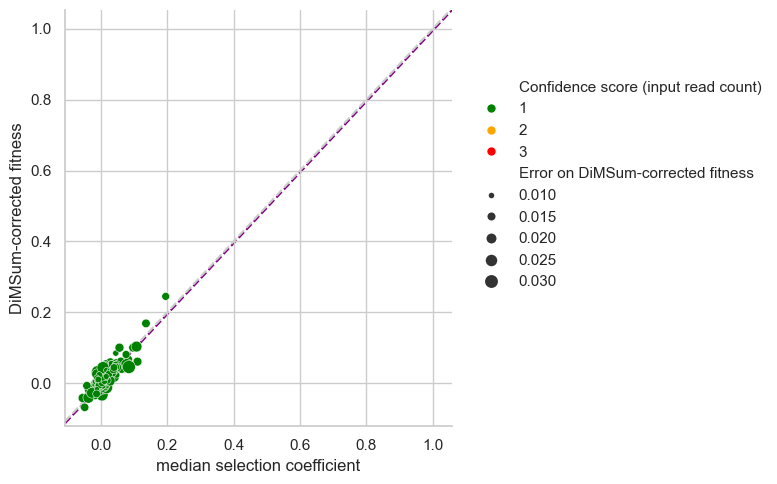

In [77]:
# Purge graph space
sns.set(rc = {'figure.figsize':(4,4)})
sns.set_theme(style='whitegrid')

if os.path.exists(dimsum_fpath):
    fig = sns.relplot(graphdf, x='x', y='y',
                      hue='h', hue_order=[1,2,3], palette=['green','orange','red'],
                      size='s', sizes=(10,100))
    fig.set(xlabel='median selection coefficient', ylabel='DiMSum-corrected fitness',)

    medianWToffset = withSyndf.median_s.iat[-1]
    fig.axes[0][0].axline((1,1), slope=1, linestyle='--', c='.8', zorder=-10)
    fig.axes[0][0].axline((1 - medianWToffset,1), slope=1, linestyle='--', c='purple', zorder=-20)
    fig._legend.texts[0].set_text('Confidence score (input read count)')
    fig._legend.texts[4].set_text('Error on DiMSum-corrected fitness')
    sns.move_legend(fig, bbox_to_anchor=(.85, 0.85), loc='upper left')

For NNK x NNK libraries, because there is more noise, the dots will almost surely be shifted from the (1,1) diagonal

This is because DiMSum normalizes values with the WT, instead of taking the median of synonymous variants (excluding the WT nucleotide sequence)

To confirm this, the diagonal in purple gives a rough estimate of where the values would fall if we had decided to normalize with the WT nucleotide sequence (median across replicates)